##### HR intensity distribution plots for 2 Australia regions (east and west),  4 periods,  every 2-degree latitude band  
   
Ming Ge Oct 2025 <br>


In [1]:
import os
import glob
import datetime  
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as co
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from matplotlib.lines import Line2D  
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.collections import LineCollection
from importlib import reload

import tc_helping
reload(tc_helping)
from tc_helping import plot_scatter_2, shortest_distance_points2poly, shortest_distance_points2country
from tc_helping import ts_trendline, ts_trendline_2, ts_trendline_en, ts_trend,  ts_trendDistr_boxplot
from tc_helping import rd_IB_info_SH, rd_IB_landfall_info_SH
from tc_helping import rd_HR_info, rd_HR_SH, rd_LENS2_info, ts_trendline_en
from tc_helping import rd_LENS2_landfall_info,  rd_LENS2_landfall_SH
from tc_helping import rd_LENS2_landfall_SH,  rd_LENS2_SH
from tc_helping import rd_HR_landfall_info, rd_HR_landfall_SH
from tc_helping import isLand
from tc_helping import plot_tc_density_IB_SH, plot_tc_density_IB_landfall_SH
from tc_helping import plot_tc_density_HR_SH, plot_tc_density_HR_landfall_SH
from tc_helping import plot_tc_density_LENS2_SH, plot_tc_density_LENS2_landfall_SH


In [2]:
def rd_vmax_HR_SH(dir_hr, year_s, year_e, extent):
    '''
    get and return Vmax of that extent(region) between year_s and year_e
    '''
    lon_s = extent[0]
    lon_e = extent[1]
    lat_s = extent[2]
    lat_e = extent[3]

    dirs = [ff for ff in glob.glob(dir_hr + "*")]
    n_mem = len(dirs)

    vmax = 0.0
    for dir in dirs:
        for year in range(year_s, year_e + 1):
            name = dir[len(dir_hr) + 8:-4]

            flnm = dir + '/' + 'CESM_HR_TC_'+ name+'_output_' + str(year) + '_SH.txt'
            
            df = pd.read_csv(flnm, delimiter=', ', engine='python')
            #print(flnm)
             
            tc_ids = np.unique(df.track_id.astype(int))
            for tc_id in tc_ids:
                df_single = df.loc[df.track_id.astype(int) == tc_id]
                lat_1d = df_single.lat.values.astype(float)
                lon_1d = df_single.lon.values.astype(float)
                lon_1d = np.where(lon_1d < 0, lon_1d+360, lon_1d)
                spd_1d = df_single.wind10.values.astype(float) 
                
                latmask = np.where((lat_1d>=lat_s) & (lat_1d < lat_e))
                if(len(latmask[0]) !=0):
                    lat_latmask = lat_1d[latmask]
                    lon_latmask = lon_1d[latmask]
                    spd_latmask = spd_1d[latmask]

                    lonmask = np.where((lon_latmask>=lon_s) & (lon_latmask < lon_e))
                    if(len(lonmask[0]) !=0):
                        #lat_final = lat_latmask[lonmask]
                        #lon_final = lon_latmask[lonmask]
                        spd_final = spd_latmask[lonmask].max()
                        if spd_final > vmax:
                            vmax = spd_final 
    return vmax                         

#### Setup

In [3]:
dir_hr   = '/glade/campaign/mmm/c3we/done/pcast/CESM_HR/'
dir_o    = '/glade/campaign/mmm/c3we/mingge/TC/DATA/'

# 4 time period
year_s = [1941, 1981, 2021, 2061]
year_e = [1980, 2020, 2060, 2100]

n_year = year_e[0] - year_s[0] + 1

n_p = len(year_s)

# 2 regions
lat_s_1d = [-41, -41]
lat_e_1d = [-9, -9]
lon_s_1d = [145, 100]
lon_e_1d = [160, 135] 

n_region = len(lat_s_1d) 


#### 2 degree lat bin width

Region 1
-41 -9 [-41 -37 -33 -29 -25 -21 -17 -13  -9]
1941-1980
1981-2020
2021-2060
2061-2100


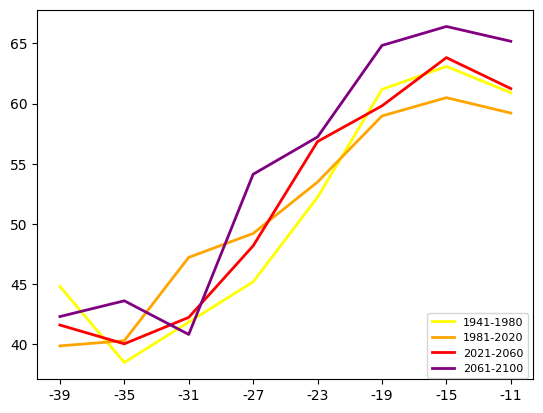

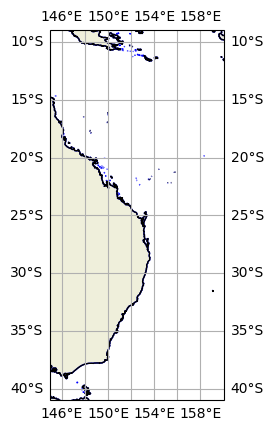

Region 2
-41 -9 [-41 -37 -33 -29 -25 -21 -17 -13  -9]
1941-1980
1981-2020
2021-2060
2061-2100


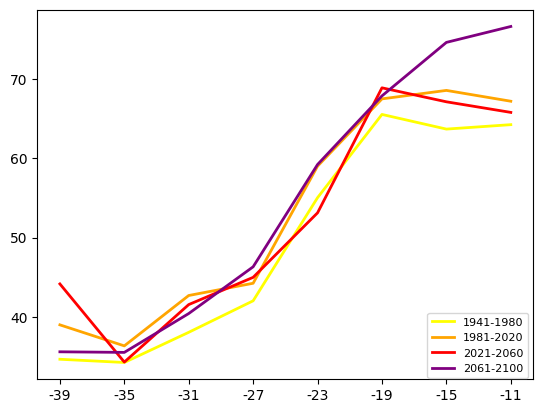

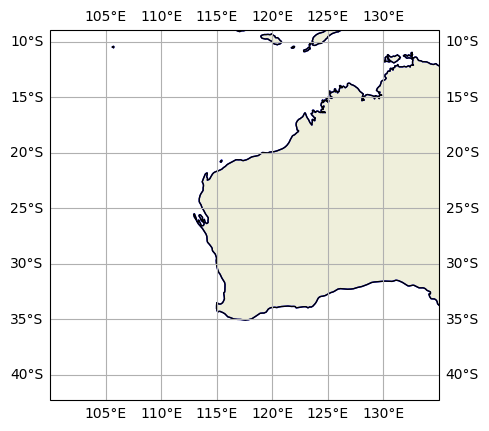

CPU times: user 9min 38s, sys: 3.56 s, total: 9min 41s
Wall time: 10min 24s


In [4]:
%%time
bin_width = 4
color_1d = ['yellow', 'orange', 'red', 'purple']
for nr in range(n_region): 
    print('Region ' + str(nr + 1))
    lat_s = lat_s_1d[nr]
    lat_e = lat_e_1d[nr]
    lon_s = lon_s_1d[nr]
    lon_e = lon_e_1d[nr]
    lon_cen = (lon_s+lon_e)*0.5
    proj   = ccrs.PlateCarree(central_longitude=lon_cen)
    extent = [lon_s, lon_e, lat_s, lat_e]
    
    data_4d = np.zeros((10, n_year, 2, n_p)) 
    
    # Define bins
    bins = np.arange(lat_s, lat_e+bin_width, bin_width)
    print(lat_s, lat_e, bins)
    n_bins = len(bins) - 1
    #print(n_bins)

    ax = plt.subplot(111) 
    for nt in range(n_p): 
        time_s = str(year_s[nt]) + '-' + str(year_e[nt])
        print(time_s)
        vmax_1d = np.zeros((n_bins))   
        for nb in range(n_bins):
            extent_bin = [lon_s, lon_e, bins[nb], bins[nb+1]]
            vmax_1d[nb] = rd_vmax_HR_SH(dir_hr, year_s[nt], year_e[nt], extent_bin) 
        ax.plot(0.5 * (bins[1:] + bins[:-1]), vmax_1d, alpha=1, linewidth=2, c=color_1d[nt], label=str(year_s[nt]) + '-' + str(year_e[nt]))

    # Set x-axis tick locations and labels
    plt.xticks(((bins[1:] + bins[:-1])/2).astype(int), ((bins[1:] + bins[:-1])/2).astype(int))
    plt.legend(loc='best', numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1, 0.195))
    plt.show()

    # map plot
    plt.figure( )    
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.set_extent(extent)      
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.LAND, edgecolor='b')
    plt.show()      

#### 2 degree lat band

Region 1
1941-1980
1981-2020
2021-2060
2061-2100


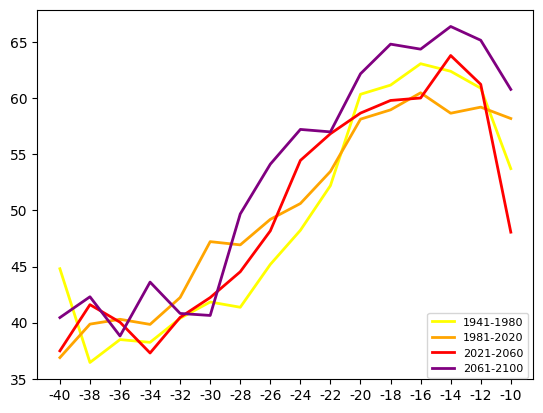

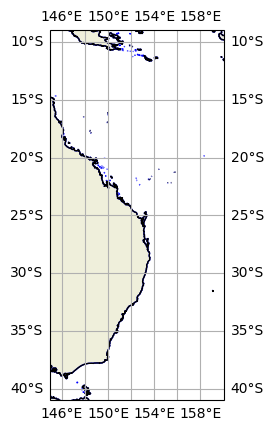

Region 2
1941-1980
1981-2020
2021-2060
2061-2100


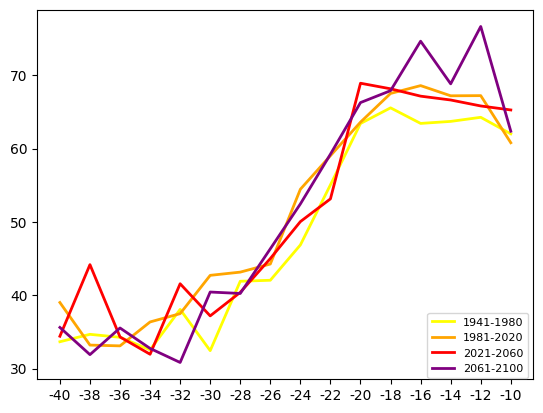

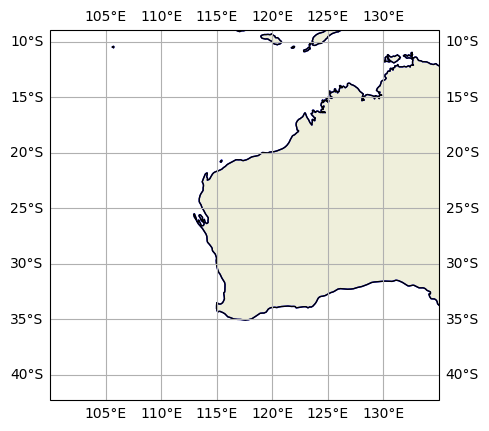

CPU times: user 19min 8s, sys: 8.77 s, total: 19min 17s
Wall time: 19min 43s


In [4]:
%%time
bin_width = 2
color_1d = ['yellow', 'orange', 'red', 'purple']
for nr in range(n_region): 
    print('Region ' + str(nr + 1))
    lat_s = lat_s_1d[nr]
    lat_e = lat_e_1d[nr]
    lon_s = lon_s_1d[nr]
    lon_e = lon_e_1d[nr]
    lon_cen = (lon_s+lon_e)*0.5
    proj   = ccrs.PlateCarree(central_longitude=lon_cen)
    extent = [lon_s, lon_e, lat_s, lat_e]
    
    data_4d = np.zeros((10, n_year, 2, n_p)) 
    
    # Define bins
    bins = np.arange(lat_s, lat_e+bin_width, bin_width)
    #print(lat_s, lat_e, bins)
    n_bins = len(bins) - 1

    ax = plt.subplot(111) 
    for nt in range(n_p): 
        time_s = str(year_s[nt]) + '-' + str(year_e[nt])
        print(time_s)
        vmax_1d = np.zeros((n_bins))   
        for nb in range(n_bins):
            extent_bin = [lon_s, lon_e, bins[nb], bins[nb+1]]
            vmax_1d[nb] = rd_vmax_HR_SH(dir_hr, year_s[nt], year_e[nt], extent_bin) 
        ax.plot(0.5 * (bins[1:] + bins[:-1]), vmax_1d, alpha=1, linewidth=2, c=color_1d[nt], label=str(year_s[nt]) + '-' + str(year_e[nt]))

    # Set x-axis tick locations and labels
    plt.xticks(((bins[1:] + bins[:-1])/2).astype(int), ((bins[1:] + bins[:-1])/2).astype(int))
    plt.legend(loc='best', numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1, 0.195))
    plt.show()

    # map plot
    plt.figure( )    
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.set_extent(extent)      
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.LAND, edgecolor='b')
    plt.show()      